<a href="https://colab.research.google.com/github/SmartPracticeschool/SBSPS-Challenge-4511-An-optimized-Warehouse-management-system/blob/master/PREDICTION_MODEL_FOR_WAREHOUSE_MANAGEMENT_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA RNN

Google Drive Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/My\ Drive

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive/Colab Notebooks


In [ ]:
cd 'Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
ls

cifar_10.ipynb  Untitled0.ipynb


## Hyper-parameters settings

In [4]:
#THE PATH FOR DATSET IS DATAROOT
dataroot = '/content/drive/My Drive/Datasets/demand fore4casting/data_more_features_final.csv'
#dataroot = '/content/data_test1 (1).csv'
batchsize = 128
nhidden_encoder = 128
nhidden_decoder = 128
ntimestep = 7
lr = 0.001
epochs = 50

## Model Architecture

In [5]:
import matplotlib.pyplot as plt

from torch.autograd import Variable

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from  sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )
        self.cnn=nn.Conv1d(self.input_size,7,1)
        #self.cnn=nn.Conv1d(self.input_size,7,1)
        #self.cnn2=nn.Conv1d(104,7,1)
        #self.cnn3=nn.Conv1d(105,7,1)


        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)

        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])
            #print( x_tilde.shape)
            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            '''
            if(x_tilde.shape[0]==105):
              x_tilde1=x_tilde
              x_tilde1.unsqueeze_(-1)
              x_tilde1=x_tilde1.expand(105,7,1)
              x_tilde1=self.cnn( x_tilde1)
              x_tilde1.unsqueeze_(-1)
              x_tilde=x_tilde1.view(105, 7) 
            
            elif(x_tilde.shape[0]==104):
              x_tilde1=x_tilde
              x_tilde1.unsqueeze_(-1)
              x_tilde1=x_tilde1.expand(104,7,1)
              x_tilde1=self.cnn( x_tilde1)
              x_tilde1.unsqueeze_(-1)
              x_tilde=x_tilde1.view(104, 7) 
            '''
            #else:
            #self.cnn=nn.Conv1d(x_tilde.shape[1],7,1)
            x_tilde1=x_tilde
            x_tilde1.unsqueeze_(-1)
            x_tilde1=x_tilde1.expand(x_tilde.shape[0],7,1)
            x_tilde1=self.cnn( x_tilde1)
            x_tilde1.unsqueeze_(-1)
            x_tilde=x_tilde1.view(x_tilde.shape[0], 7) 
           
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())


class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)
        
        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))
        
        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.linear_reg=LinearRegression()
        self.encoder_num_hidden = encoder_num_hidden
        self.linear=nn.Linear(128,128)
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        #self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.device = torch.device('cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)



        self.Linear_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.linear.parameters()),
                                           lr=self.learning_rate)




        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]
                
                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])





            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss: ", self.epoch_losses[epoch])

            if epoch % 10 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='upper left')
                plt.show()

            # # Save files in last iterations
            # if epoch == self.epochs - 1:
            #     np.savetxt('../loss.txt', np.array(self.epoch_losses), delimiter=',')
            #     np.savetxt('../y_pred.txt',
            #                np.array(self.y_pred), delimiter=',')
            #     np.savetxt('../y_true.txt',
            #                np.array(self.y_true), delimiter=',')

    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()



        self.Linear_optimizer.zero_grad()


        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))
         
        if (y_pred.shape[0]==128):
          y_pred=self.linear(y_pred.view(-1,y_pred.shape[0]*1))
          y_pred=y_pred.T
        #print(y_pred.shape)
      

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))
        
        y_true = y_true.view(-1, 1)
        y_pred1=y_pred
        #y_pred =y_pred.detach().numpy()
        #self.linear_reg.fit(y_true,y_pred)
        #y_pred=self.linear_reg.predict(y_true)

        
        #y_pred=torch.abs(y_pred)
        loss = self.criterion(y_pred1, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()


        self.Linear_optimizer.step()


        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            
            y_pred_copy=y_pred
                  
            if (y_pred[i:(i + self.batch_size)].shape[0]==128):
                y_pred1 =y_pred[i:(i + self.batch_size)]  
                y_pred1=torch.from_numpy(y_pred1)
                y_pred1=y_pred1.float()
                
                y_pred1=self.linear(y_pred1.view(-1,y_pred[i:(i + self.batch_size)].shape[0]*1))

                #y_pred[:,i:(i + self.batch_size)]=self.linear(y_pred1.view(-1,y_pred1.shape[0]*1))
                y_pred1=y_pred1.T  
                y_pred1=y_pred1.detach().numpy()
                y_pred[i:(i + self.batch_size)]= y_pred1.ravel()

            '''
               
        if (y_pred.shape[0]==128):
          y_pred=self.linear(y_pred.view(-1,y_pred.shape[0]*1))
          y_pred=y_pred.T

            y_pred= y_pred.reshape(-1, 1)

            #y_pred[i:(i + self.batch_size)]=self.linear_reg.predict(y_pred[i:(i + self.batch_size)])
            

            y_pred=y_pred.reshape(y_pred_copy.shape)
            '''

            i += self.batch_size

        return y_pred
    def predict(self,X1,days):
        X1=X1
        y_pred = np.zeros(X1.shape[0])
        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, X1.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
        
            
                    X[j, :, :] = X1[range(
                        batch_idx[j]  - self.T, batch_idx[j]  - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j]  - self.T, batch_idx[j]  - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            
            y_pred_copy=y_pred
                  
            if (y_pred[i:(i + self.batch_size)].shape[0]==128):
                y_pred1 =y_pred[i:(i + self.batch_size)]  
                y_pred1=torch.from_numpy(y_pred1)
                y_pred1=y_pred1.float()
                
                y_pred1=self.linear(y_pred1.view(-1,y_pred[i:(i + self.batch_size)].shape[0]*1))
                y_pred1=y_pred1.T  
                y_pred1=y_pred1.detach().numpy()
                y_pred[i:(i + self.batch_size)]= y_pred1.ravel()
            i += self.batch_size
        plt.ioff()
        plt.figure()
        plt.plot(range(1, 1 + len(y_pred[:days])),y_pred[:days], label="Predicted")
        plt.legend(loc='upper left')
        plt.show() 
        return y_pred

## Util Function

In [6]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def read_data(input_path, debug=True):
    """Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.

    """
    df = pd.read_csv(input_path, nrows=365 if debug else None)
    #df = pd.read_csv(input_path)
    df=df.drop(['id','date','Unnamed: 0.1'], axis = 1) 
    
    # X = df.iloc[:, 0:-1].values
    X = df.loc[:, [x for x in df.columns.tolist() if x != 'unit_sales']].to_numpy()

    # y = df.iloc[:, -1].values
    y = np.array(df.unit_sales)
    y=y.reshape(-1, 1) 
    #use the below function if you want to normalize
    '''
     
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(y)
    '''
   # y= scaler.transform(y)
    #y = preprocessing.scale(y)
    print(y)
    y=y.reshape(-1)
    return X, y

## Main

==> Load dataset ...
[[ 6.]
 [12.]
 [ 2.]
 ...
 [ 5.]
 [ 4.]
 [ 2.]]
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...
Epochs:  0  Iterations:  945  Loss:  19.558044861233423


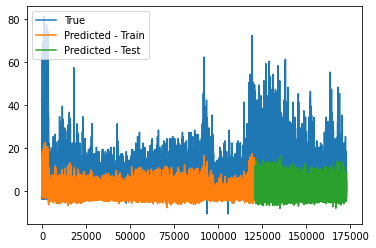

Epochs:  10  Iterations:  10395  Loss:  0.5302771529439029


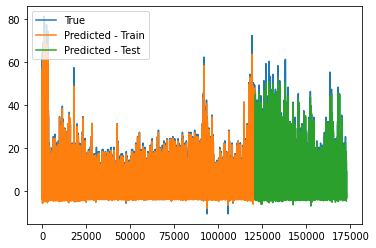

Epochs:  20  Iterations:  19845  Loss:  0.42299621279681565


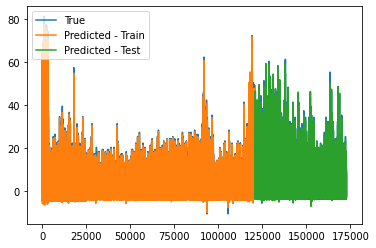

Epochs:  30  Iterations:  29295  Loss:  0.3840884895354667


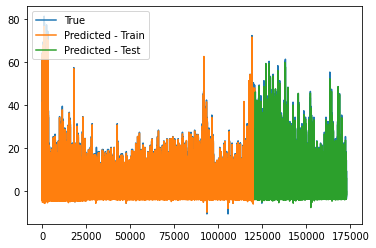

Epochs:  40  Iterations:  38745  Loss:  0.368975822528499


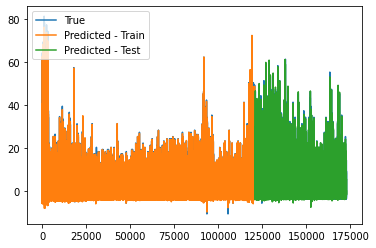

Finished Training


In [5]:
# Read dataset
import warnings
warnings.filterwarnings("ignore")
print("==> Load dataset ...")
X, y = read_data(dataroot, debug=False)

# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
#model.to(device)
model.train()

# Prediction
y_pred = model.test()

fig1 = plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.savefig("1.png")
plt.close(fig1)

fig2 = plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.savefig("2.png")
plt.close(fig2)

fig3 = plt.figure()
plt.plot(model.y[model.train_timesteps:], label="True")
plt.plot(y_pred, label='Predicted')

plt.legend(loc='upper left')
plt.savefig("3.png")
plt.close(fig3)
print('Finished Training')

SAVING THE TRAINEDD MODEL 

In [ ]:
torch.save(model, '/content/drive/My Drive/Datasets/demand fore4casting/finished.pth')


# LOADING THE  TRAINED MODEL

In [7]:
model = torch.load('/content/drive/My Drive/Datasets/demand fore4casting/finished.pth')

FUNTION TO TAKE CUSTOM INPUT AND FEED IT TO MODEL FOR PREDICTION


In [9]:
import random
def backend():
  
  days=input("input number of days" )
  store_nbr=input("enter the store nmbr ranging from 1 to 54: ")
  item_nbr=input("enter the item nmbr any one of the following (108696),(164088),(804098),(1695936),(2032088)")
  days = int(days)
  store_nbr = int(store_nbr)
  item_nbr = int(item_nbr)

  
  
  dcoilwtico=[]
  itemnbr=[]
  storenbr=[]
  onpromotion=[]
  transactions=[]
  type1=[]
  y=days%128
  days1=days+y
  for x in range(days1):
    itemnbr.append(item_nbr)
    storenbr.append(store_nbr)
    dcoilwtico.append(random.randint(26,110))
    onpromotion.append( random.randint(0,1))
    transactions.append(random.randint(6,8359))
    type1.append(random.randint(0,1))
  unnamed=list(range(0,days1))
  dict1={'unnamed':unnamed,'store_nbr':storenbr,'item_nbr':itemnbr,'onpromotion':onpromotion,'dcoilwtico':dcoilwtico,'transactions':transactions,
        'type':type1}
  data=pd.DataFrame(dict1)
  return data ,days 
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def read_data1(input, ):
    """Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.

    """
    df = input
    #df = pd.read_csv(input_path)
   
    
    # X = df.iloc[:, 0:-1].values
    X = df.loc[:, [x for x in df.columns.tolist() if x != 'unit_sales']].to_numpy()

    # y = df.iloc[:, -1].values
    '''
    y = np.array(df.unit_sales)
    y=y.reshape(-1, 1) 

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(y)

   # y= scaler.transform(y)
    #y = preprocessing.scale(y)
    print(y)
    y=y.reshape(-1)
    '''
    return X

# SAMPLE OUTPUT FROM A CUSTOM INPUT

input number of days128
enter the store nmbr ranging from 1 to 54: 45
enter the item nmbr any one of the following (108696),(164088),(804098),(1695936),(2032088)2032088


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


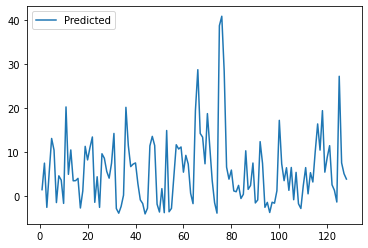

In [10]:

x,d= backend()

pred=model.predict(read_data1(x),d)
pred = np.absolute(pred)
#print(pred[:d][d-1])
